# Sound Recognition - Machine Learning Model

### Carlos Granados, 11.2020

Model for sound recongnition, using machine learning models. Features obtained by wavelet transformations, MFCCs, spectral representation, chroma, Mel-scale and Tonnetz.

## 0. Load Packages

In [166]:
# Standard python libraries:
import os
import numpy as np
import math

# To specify path to a file, for any OS!
from pathlib import Path

# To manage ZIP files:
from zipfile import ZipFile

# To manage TAR files:
import tarfile

# To work with streams:
from io import BytesIO

# To work with sound files:
import soundfile as sf
import librosa
from librosa.feature import melspectrogram, mfcc, chroma_stft, tonnetz
# import scikits.samplerate as sks
import scipy.signal as scipy_signal

#Librosa 0.8.0 DOI:10.5281/zenodo.3955228
# McFee, Brian, Colin Raffel, Dawen Liang, Daniel PW Ellis, Matt McVicar,
# Eric Battenberg, and Oriol Nieto. “librosa: Audio and music signal analysis
# in python.” In Proceedings of the 14th python in science conference, pp. 18-25. 2015.

# Wavelet transformation:
import pywt

# Libraries to make plots and related
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.pyplot import imshow

%matplotlib inline

# Machine Learning
# Auxiliary functions and utilities
import sklearn
from sklearn.decomposition import PCA
from sklearn.utils import shuffle, resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Machine Learning Classifiers
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# To save and load models
from joblib import dump, load

# Print versions:
print('Matplotlib Version   : {}'.format(matplotlib.__version__))
print('scikit-learn Version : {}'.format(sklearn.__version__))
print('pywt Version         : {}'.format(pywt.__version__))
print('SoundFile Version    : {}'.format(sf.__version__))
print('librosa Version      : {}'.format(librosa.__version__))

Matplotlib Version   : 3.1.2
scikit-learn Version : 0.23.2
pywt Version         : 1.1.1
SoundFile Version    : 0.10.3
librosa Version      : 0.8.0


***
---




## 1. Sound Files - Reading the Data

In order to develope our machine learning model for sound recognition, we use the sound files given by from J. Salamon, C. Jacoby and J. P. Bello, "*A Dataset and Taxonomy for Urban Sound Research*", 22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014. [Webapge source](https://urbansounddataset.weebly.com/)

In [2]:
data_folder = '/data/Data/sounds/UrbanSound/data/'
sound_tarfile = 'UrbanSound_Files.tar.gz'
path_file = os.path.join(data_folder, sound_tarfile)#data_folder + zip_file
print('Path : {}'.format(path_file))

Path : /data/Data/sounds/UrbanSound/data/UrbanSound_Files.tar.gz


In [ ]:
# For ZIP files:
#ZipFile.namelist(sound_file)

# For TAR files
#TarFile = tarfile.open(path_file)
#TarFile.getnames()

# NOTE: tar files were consuming too much RAM!

In [ ]:
# List files in a directory
for path, subdirs, files in os.walk(data_folder):
    for name in files:
        print(os.path.join(path, name))

Function to transform `mp3` files to `wav`.

**Note:** I decided to transform them to WAVs, because the MP3s were consuming too much memory!

In [3]:
def to_wav(file_name, tmp_folder='./tmp_sound/'):
    if not os.path.isdir(tmp_folder):
        cmd = 'mkdir {}'.format(tmp_folder)
        os.system(cmd)
    else:
        cmd = 'rm {}/*'.format(tmp_folder)
    path, name = os.path.split(file_name)
    f_name, f_ext = os.path.splitext(name)
    f_name = f_name + '.wav'
    new_file = os.path.join(tmp_folder, f_name)
    cmd = "ffmpeg -i {0} -vn -acodec pcm_s16le -ac 1 -ar 44100 -f wav {1}".format(file_name, new_file)
    os.system(cmd)
    return new_file

Function to transform to a mon-channel:

In [4]:
def to_mono(data):
    if data.ndim > 1:
        data = np.mean(data, axis=1)
    return data

In [5]:
audio_data = []
labels = []
sampling_rate = []
file_names = []

# Obj. fur *.zip: ZipFiles, for *.tar.gz: TarFile

#for file_name in TarFile.getnames():
for path, subdirs, files in os.walk(data_folder):
    for name in files:
        file_name = os.path.join(path, name)
        #print(file_name)

        # Skip directories
        if not os.path.basename(file_name):
            continue

        # Obtain extension of each file
        f_name, f_ext = os.path.splitext(file_name)
        # If file does not have an extension, loop again
        if f_ext == '': #f_ext == '.mp3' or f_ext == '':
            continue

        # Check if file belongs to a given category
        base_path = 'UrbanSound/data/'
        audio_file = None
        #if file_name.startswith(base_path + 'air_conditioner/'):
        if '/air_conditioner/' in file_name:
            #labels.append(0)
            label_file = 0
            audio_file = file_name
        #elif file_name.startswith(base_path + 'car_horn/'):
        elif '/car_horn/' in file_name:
            #labels.append(1)
            #audio_file = TarFile.extractfile(file_name)
            label_file = 1
            audio_file = file_name
        ##elif file_name.startswith(base_path + 'drilling/'):
        elif '/drilling/' in file_name:
            #labels.append(2)
            #audio_file = TarFile.extractfile(file_name)
            label_file = 2
            audio_file = file_name
        ##elif file_name.startswith(base_path + 'siren/'):
        #elif '/siren/' in file_name:
        #    #labels.append(5)
        #    #audio_file = TarFile.extractfile(file_name)
        #    label_file = 3
        #    audio_file = file_name
        #else:
            #print("Unknown file class...")
        
        # If the audio file belongs to one of the desired categories,
        # Then readed it and process it (sample rates, to mono audio...)
        if audio_file is not None:
            file_names.append(file_name)
            print(file_name)
            if f_ext != '.wav': #f_ext == '.mp3':
                #data, samplerate = librosa.load(audio_file)
                audio_file = to_wav(audio_file)
            #else:
                #tmp = BytesIO(read(audio_file))
            data, samplerate = sf.read(audio_file)
            # Transform to mono:
            data = to_mono(data)
            # Check Sampling Rate
            if(samplerate != 44100):
#                 data_inp = np.asarray(data)
#                 print(data_inp.shape, samplerate)
                scipy_signal.resample(data, int(len(data)*samplerate/44100))
#                 data = sks.resample(data_inp, samplerate/44100, 'sinc_best')
#                 data = librosa.resample(data, samplerate, 44100)
                samplerate = 44100
            # Save labels, audio data and sampling rates
            labels.append(label_file)
            audio_data.append(data)
            sampling_rate.append(samplerate)

/data/Data/sounds/UrbanSound/data/drilling/139000.wav
/data/Data/sounds/UrbanSound/data/drilling/180937.wav
/data/Data/sounds/UrbanSound/data/drilling/181624.wav
/data/Data/sounds/UrbanSound/data/drilling/57696.wav
/data/Data/sounds/UrbanSound/data/drilling/69598.wav
/data/Data/sounds/UrbanSound/data/drilling/77774.mp3
/data/Data/sounds/UrbanSound/data/drilling/50413.wav
/data/Data/sounds/UrbanSound/data/drilling/71079.wav
/data/Data/sounds/UrbanSound/data/drilling/156362.wav
/data/Data/sounds/UrbanSound/data/drilling/135849.wav
/data/Data/sounds/UrbanSound/data/drilling/77751.wav
/data/Data/sounds/UrbanSound/data/drilling/63095.wav
/data/Data/sounds/UrbanSound/data/drilling/84699.wav
/data/Data/sounds/UrbanSound/data/drilling/46668.wav
/data/Data/sounds/UrbanSound/data/drilling/95562.wav
/data/Data/sounds/UrbanSound/data/drilling/71088.wav
/data/Data/sounds/UrbanSound/data/drilling/146244.wav
/data/Data/sounds/UrbanSound/data/drilling/140824.wav
/data/Data/sounds/UrbanSound/data/drill

/data/Data/sounds/UrbanSound/data/car_horn/44278.wav
/data/Data/sounds/UrbanSound/data/car_horn/43803.wav
/data/Data/sounds/UrbanSound/data/car_horn/138465.wav
/data/Data/sounds/UrbanSound/data/car_horn/155283.wav
/data/Data/sounds/UrbanSound/data/car_horn/175851.wav
/data/Data/sounds/UrbanSound/data/car_horn/176003.wav
/data/Data/sounds/UrbanSound/data/car_horn/162541.wav
/data/Data/sounds/UrbanSound/data/car_horn/145577.wav
/data/Data/sounds/UrbanSound/data/car_horn/72259.mp3
/data/Data/sounds/UrbanSound/data/car_horn/26185.wav
/data/Data/sounds/UrbanSound/data/car_horn/161010.wav
/data/Data/sounds/UrbanSound/data/car_horn/175852.wav
/data/Data/sounds/UrbanSound/data/car_horn/117536.wav
/data/Data/sounds/UrbanSound/data/car_horn/32417.wav
/data/Data/sounds/UrbanSound/data/car_horn/26176.wav
/data/Data/sounds/UrbanSound/data/car_horn/203956.flac
/data/Data/sounds/UrbanSound/data/car_horn/175844.wav
/data/Data/sounds/UrbanSound/data/car_horn/71439.mp3
/data/Data/sounds/UrbanSound/data/

Check the obtained lists:

In [6]:
print(len(labels))
print(labels)

281
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [7]:
print(len(sampling_rate))
print(sampling_rate)

281
[44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 44100, 4

In [8]:
print(len(audio_data))
#print(audio_data)

281


We define now a function that will help us to save and load files...

In [133]:
def load_save(var, act, data=None, file_name=None):
    """
    Function to load from a file or save to a file some numpy arrays
    var : (str), variable to load
        : = 'sound', 'labels'
    act : (str), action to perform
        : = 'load', 'save'
    data : (np array) data to save
    """
    # Folder and file names
    folder_name = './saved/'
    file0_name = 'audio_data.npy'
    file1_name = 'labels_data.npy'
    file2_name = 'feat_250_data.npy'
    file3_name = 'feat_mfcc_125_data.npy'
    # Full file names, inclusing path
    file = {}
    file['sound'] = os.path.join(folder_name, file0_name)
    file['labels'] = os.path.join(folder_name, file1_name)
    file['feat_wt'] = os.path.join(folder_name, file2_name)
    file['feat_mfcc'] = os.path.join(folder_name, file3_name)
    if var not in file.keys():
        file[var] = os.path.join(folder_name, file_name)
    
    full_path = file[var]
    
    if act == 'save':

        # Check if folder exists
        if not os.path.isdir(folder_name):
            cmd = 'mkdir {}'.format(folder_name)
            os.system(cmd)
        # Save to npy files
        np.save(full_path, data)
        print(var + ' saved')

    elif act == 'load':
        
        # Check if data is already in memory or not...
        try:
            if var == 'sound':
                audio_data
            elif var == 'labels':
                labels
            else:
                feat
        except NameError:
            data = np.load(full_path, allow_pickle=True)
            print(var + ' loaded')
        else:
            print(var + ' already loaded')

        return data           

***
---




## 2. Check the Data - Feature Exploration

Now we plot some of the obtained sounds... We start defining a function to plot the sound files:

In [150]:
def plot_sound(data):
    """
    Function to plot the profile of an audio file...
    """
    gblue = '#0288D1'
    fig = plt.figure(figsize=(14, 6))
    plt.plot(data, c=gblue)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.xlim(0, len(data))
    plt.ylim(-1.1, 1.1)

In [151]:
# Function to plot contout plots

def featPlot(coeffs, cmap='inferno', title=None):
    """
    Function to plot the contour plot for different feature representations
    """
    fig, axs = plt.subplots(3, 2, figsize=(20, 10))
    for i, ax in enumerate(axs):
        #Obtain Min. and Max. values, to obtain a symmetric color bar
        vmin0, vmax0 = np.amin(coeffs[i][0]), np.amax(coeffs[i][0])
        val0 = max(abs(vmin0), abs(vmax0))
        vmin1, vmax1 = np.amin(coeffs[i][0]), np.amax(coeffs[i][1])
        val1 = max(abs(vmin1), abs(vmax1))
        # Plot data
        ax0 = ax[0].imshow(coeffs[i][0], cmap=cmap, aspect='auto', vmin=-val0, vmax=val0)
        cbar = fig.colorbar(ax0, ax=ax[0], extend='both')
        ax1 = ax[1].imshow(coeffs[i][1], cmap=cmap, aspect='auto', vmin=-val1, vmax=val1)
        cbar = fig.colorbar(ax1, ax=ax[1], extend='both')
    if title != None:
        fig.suptitle(title)

In [148]:
def find_indxs(val, num_ind, list_):
    "Function to find the first num_ind positions of val in the list"
    out = [i for i, value in enumerate(list_) if value == val]
    if len(out) > 0:
        out = out[0:num_ind]
    return out

---

### 2.1 Audio Plots

---

#### 2.1.1 Amplitude Plots

Let's check the data for the 1st category (label = 0, air conditioner):

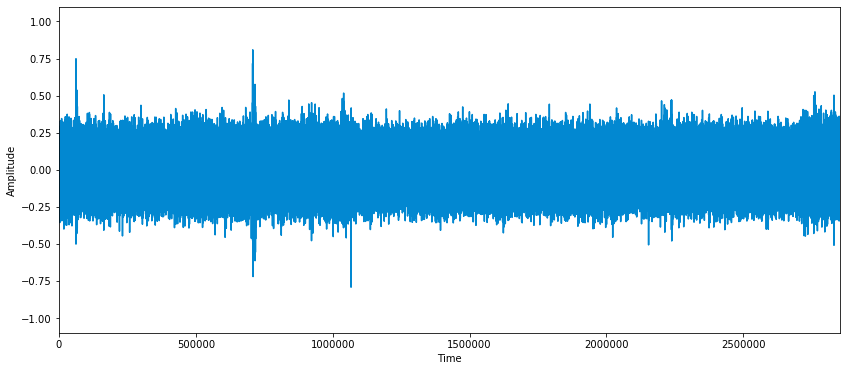

In [152]:
out0 = find_indxs(0, 10, labels)
plot_sound(audio_data[out0[0]])

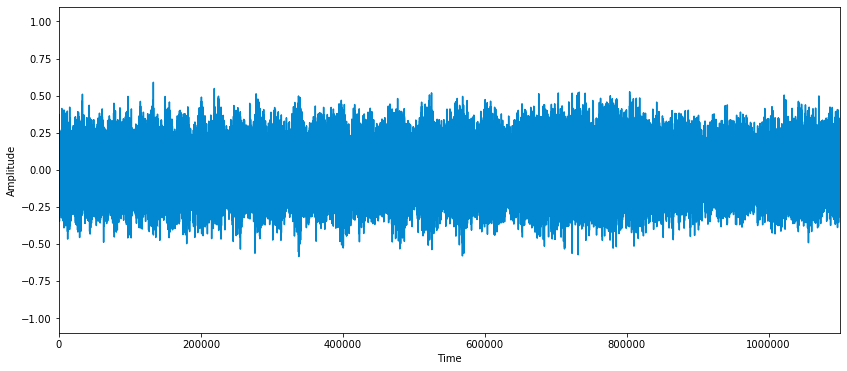

In [14]:
plot_sound(audio_data[out0[5]])

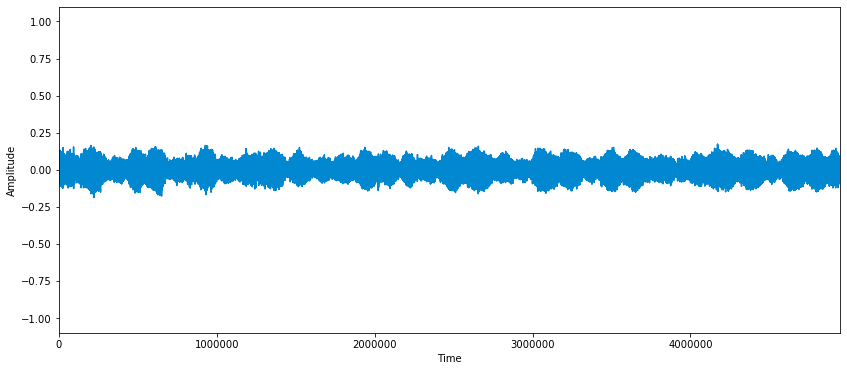

In [15]:
plot_sound(audio_data[out0[-1]])

2nd category (label = 1, car horn):

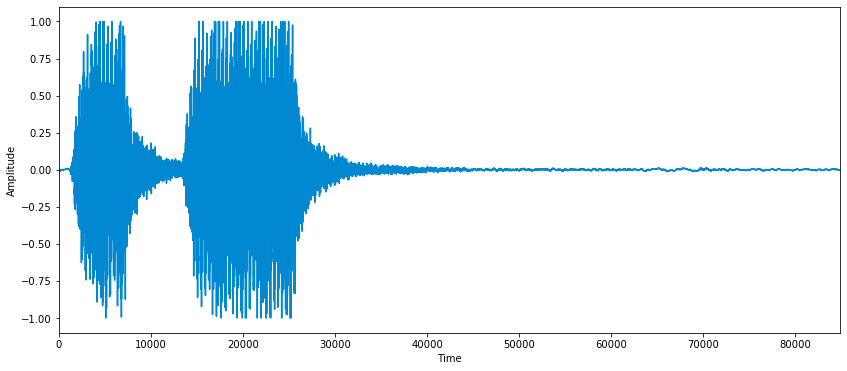

In [153]:
out1 = find_indxs(1, 10, labels)
plot_sound(audio_data[out1[0]])

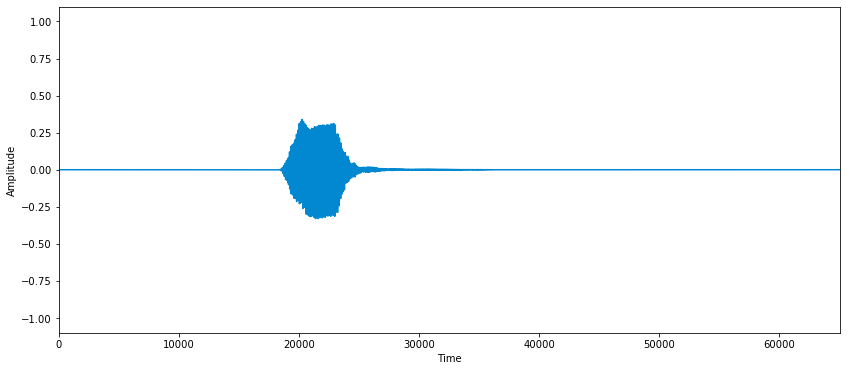

In [17]:
plot_sound(audio_data[out1[4]])

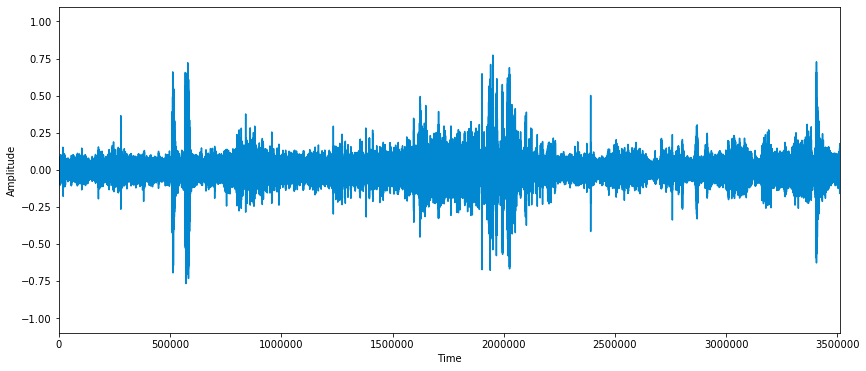

In [18]:
plot_sound(audio_data[out1[-1]])

And the 3rd category (label = 2, drilling):

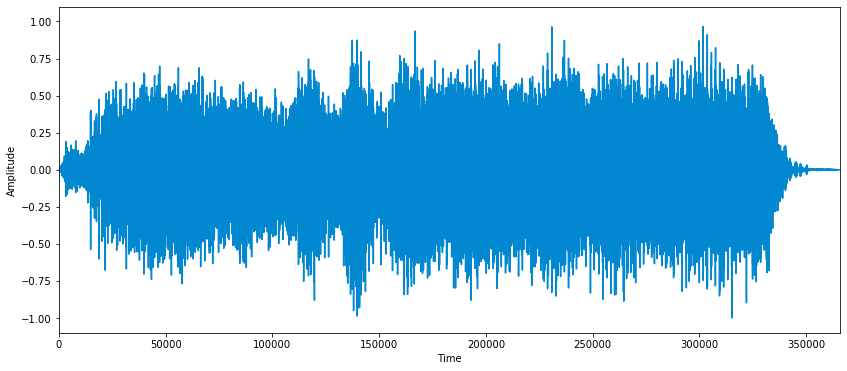

In [154]:
out2 = find_indxs(2, 10, labels)
plot_sound(audio_data[out2[0]])

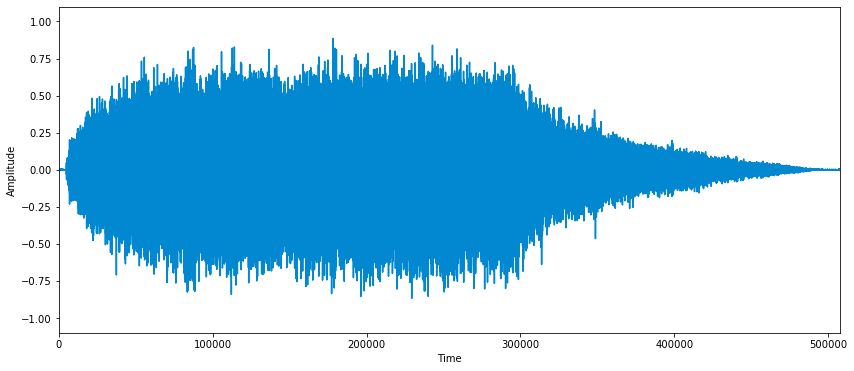

In [20]:
plot_sound(audio_data[out2[6]])

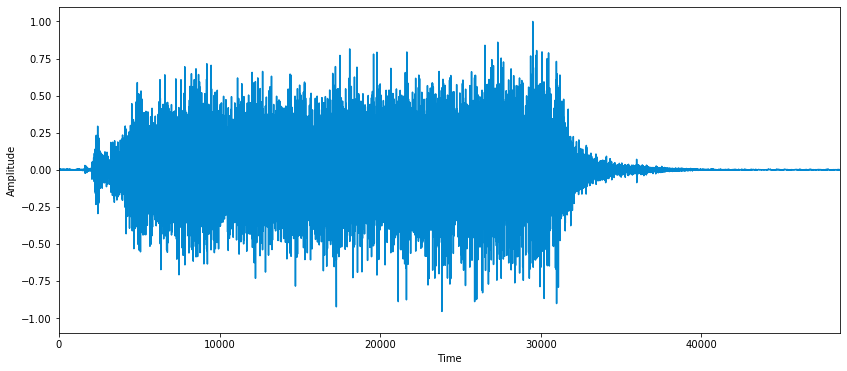

In [21]:
plot_sound(audio_data[out2[-1]])

---




#### 2.1.2 Wavelet transforms

Now we proceed to check the wavelet transform for some of the data sets. To do so, we use the function `cwt` from the `pywt` library. The scales must be given, and we calculate them in the range `[1, 100]`. We also use the Morlet wavelet (`morl`).

In [158]:
scales = np.arange(1, 101)
coeffs= []

# For the 1st label
coeffa, freq1 = pywt.cwt(audio_data[out0[0]][:25000], scales, "morl")
coeffb, freq2 = pywt.cwt(audio_data[out0[-1]][:25000], scales, "morl")
coeffs.append([coeffa, coeffb])

#For the 2nd label
coeffa, freq1 = pywt.cwt(audio_data[out1[0]][:25000], scales, "morl")
coeffb, freq2 = pywt.cwt(audio_data[out1[-1]][:25000], scales, "morl")
coeffs.append([coeffa, coeffb])

#For the 3rd label
coeffa, freq1 = pywt.cwt(audio_data[out2[0]][:25000], scales, "morl")
coeffb, freq2 = pywt.cwt(audio_data[out2[-1]][:25000], scales, "morl")
coeffs.append([coeffa, coeffb])

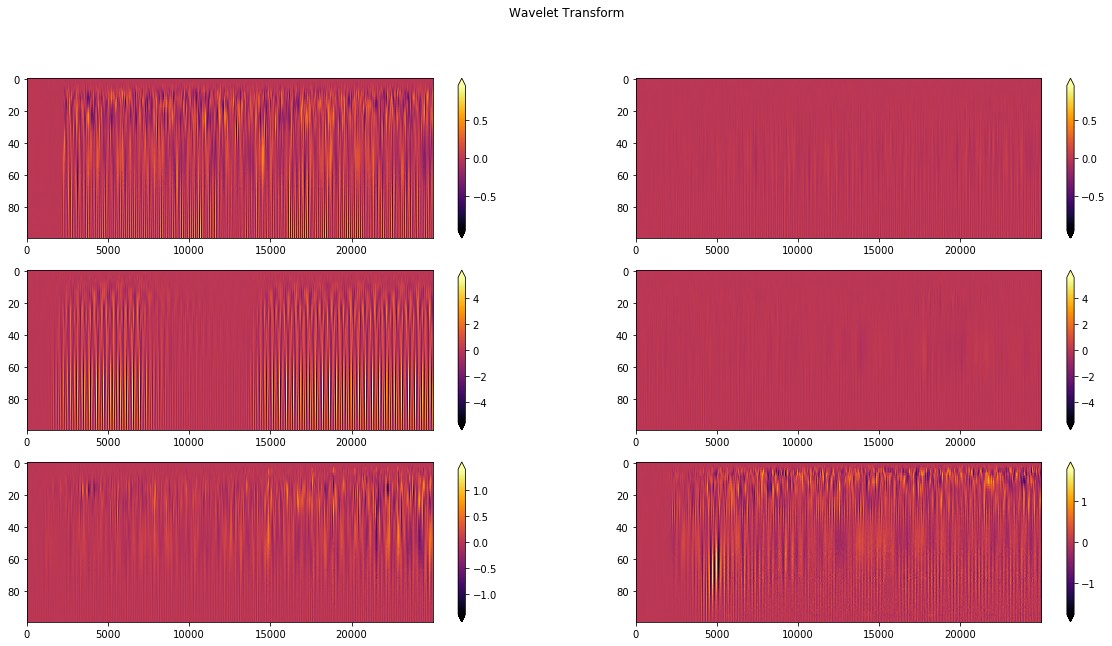

In [159]:
featPlot(coeffs, title='Wavelet Transform')

And some 3D plots...

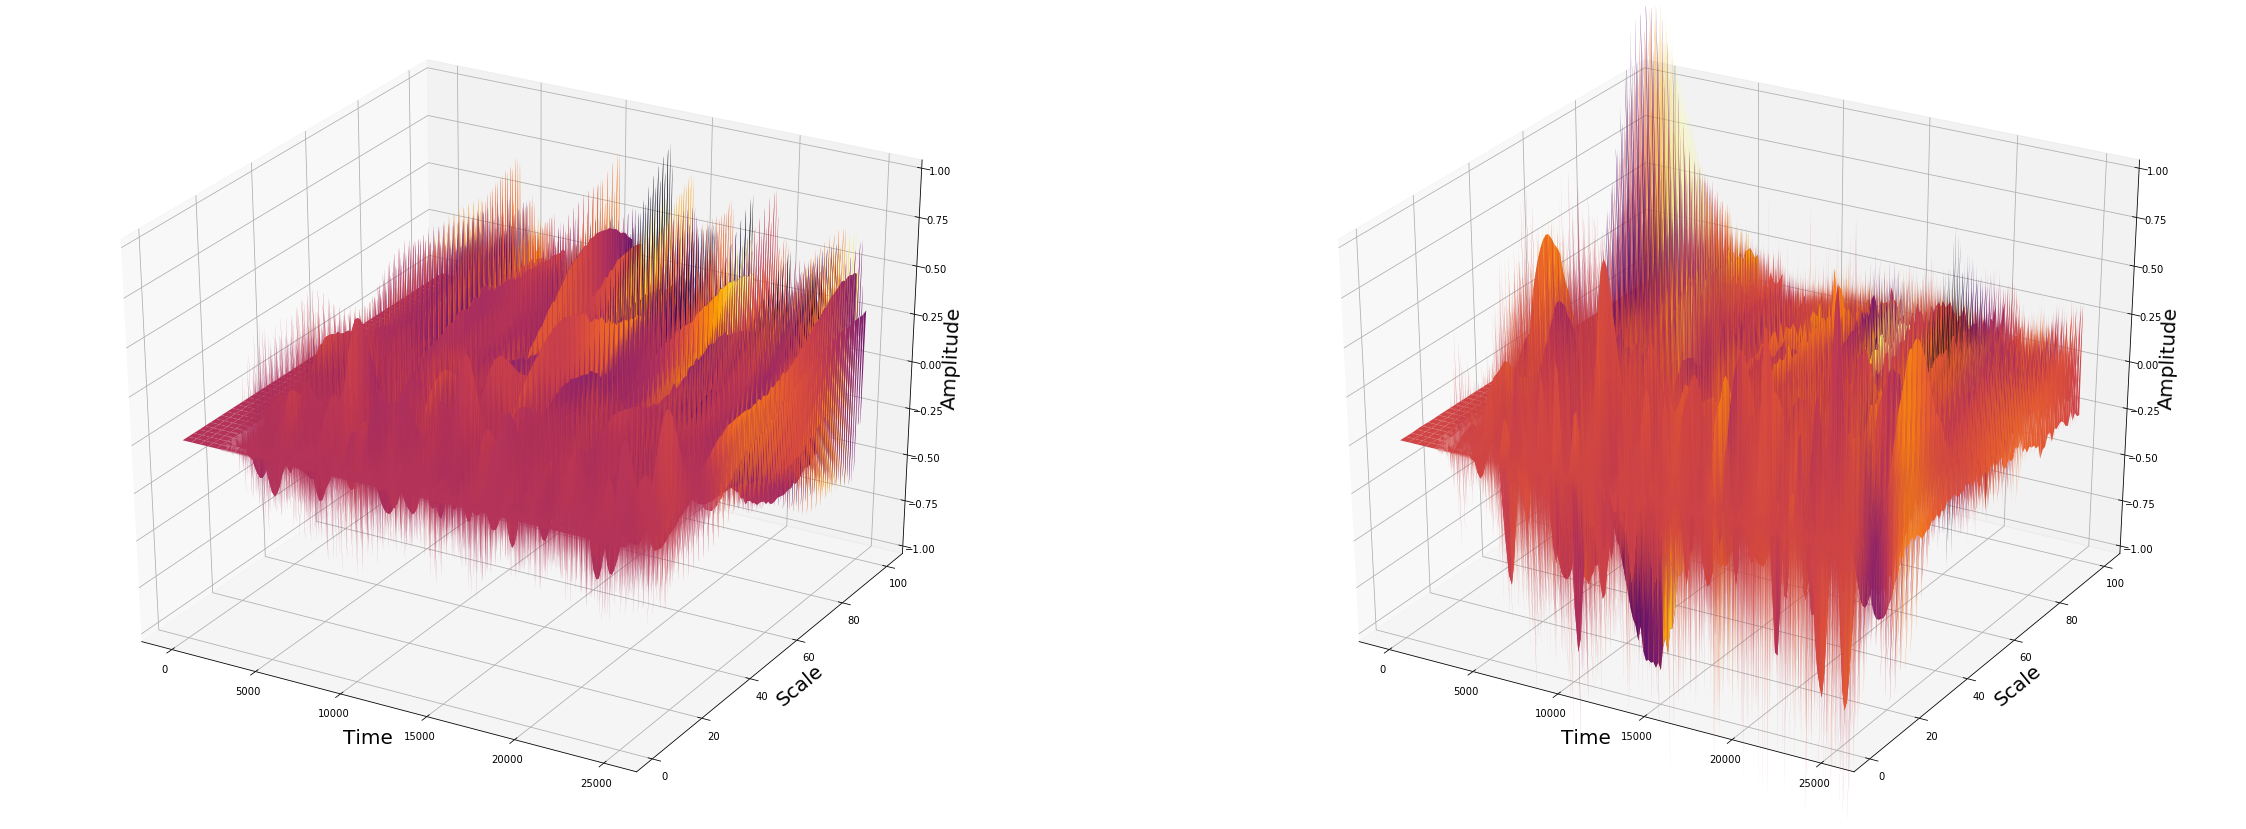

In [160]:
fig = plt.figure(figsize=(40, 15))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')

Y = np.arange(1, 101, 1)
X = np.arange(1, 25001, 1)

X, Y = np.meshgrid(X, Y)
ax1.plot_surface(X, Y, coeffs[0][0], cmap='inferno', linewidth=0, antialiased=True)

ax1.set_xlabel('Time', fontsize=20)
ax1.set_ylabel('Scale', fontsize=20)
ax1.set_zlabel('Amplitude', fontsize=20)
ax1.set_zlim3d(-1, 1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax2.plot_surface(X, Y, coeffs[-1][-1], cmap='inferno', linewidth=0, antialiased=True)

ax2.set_xlabel('Time', fontsize=20)
ax2.set_ylabel('Scale', fontsize=20)
ax2.set_zlabel('Amplitude', fontsize=20)
ax2.set_zlim3d(-1, 1)

plt.show()

In [27]:
# To save memory...
del X, Y
del coeffs
del freq1, freq2

---




#### 2.1.3 Mel Spectrogram

We define now the Mel-Scale spectrogram. To obtain it, we use the function `melspectrogram` from the `librosa.feature` library:

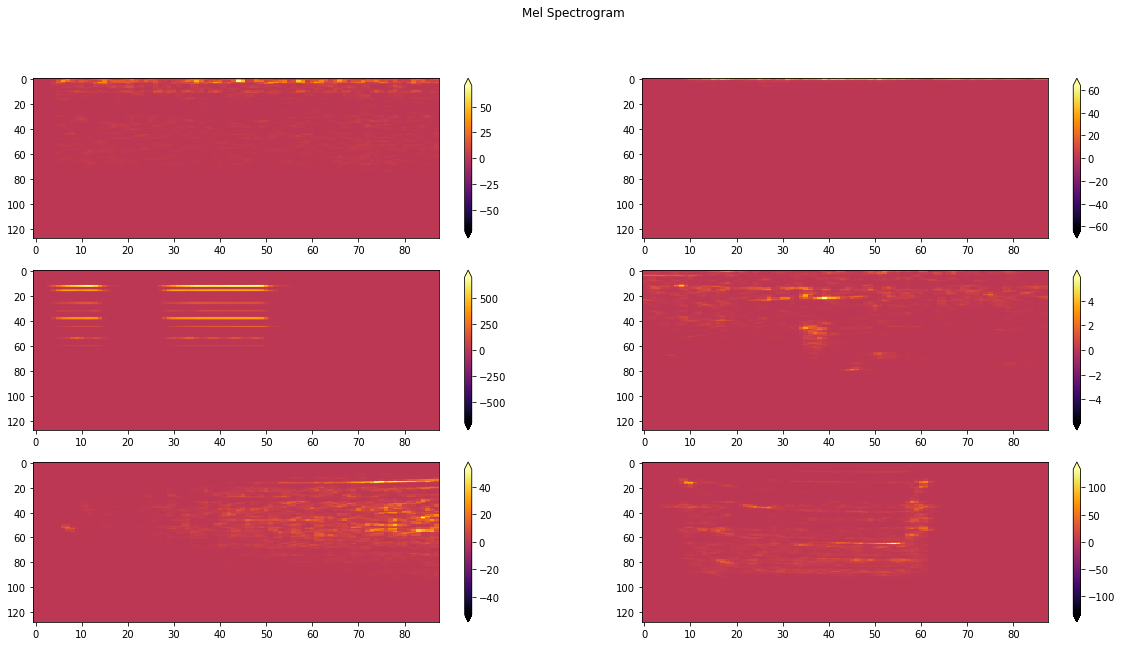

In [28]:
coeffs= []
from librosa.feature import melspectrogram

# For the 1st labelchroma =
coeffa = melspectrogram(y=audio_data[out0[0]][:45000], sr=44100)
coeffb = melspectrogram(y=audio_data[out0[-1]][:45000], sr=44100)
coeffs.append([coeffa, coeffb])

#For the 2nd label
coeffa = melspectrogram(y=audio_data[out1[0]][:45000], sr=44100)
coeffb = melspectrogram(y=audio_data[out1[-1]][:45000], sr=44100)
coeffs.append([coeffa, coeffb])

#For the 3rd label
coeffa = melspectrogram(y=audio_data[out2[0]][:45000], sr=44100)
coeffb = melspectrogram(y=audio_data[out2[-1]][:45000], sr=44100)
coeffs.append([coeffa, coeffb])

# Plot all
featPlot(coeffs,title='Mel Spectrogram')

---




#### 2.1.4 Mel-Frequency Cepstral Coefficients

We visualize now the Mel-Frequency Cepstral Coefficients (MFCCs). To do so, we use the function `mfcc` from the `librosa.feature` library:

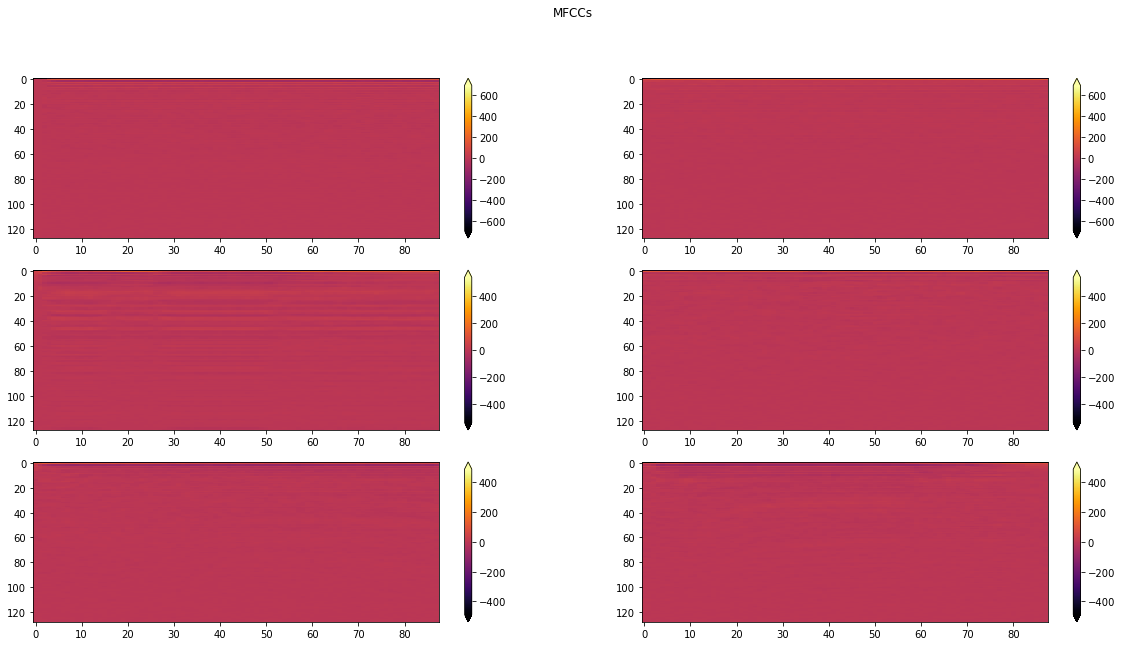

In [161]:
coeffs= []
dim_feat = 128
num_pts = 25000

# For the 1st label
coeffa = mfcc(y=audio_data[out0[0]][:45000], sr=44100, n_mfcc=dim_feat)
coeffb = mfcc(y=audio_data[out0[-1]][:45000], sr=44100, n_mfcc=dim_feat)
coeffs.append([coeffa, coeffb])

#For the 2nd label
coeffa = mfcc(y=audio_data[out1[0]][:45000], sr=44100, n_mfcc=dim_feat)
coeffb = mfcc(y=audio_data[out1[-1]][:45000], sr=44100, n_mfcc=dim_feat)
coeffs.append([coeffa, coeffb])

#For the 3rd label
coeffa = mfcc(y=audio_data[out2[0]][:45000], sr=44100, n_mfcc=dim_feat)
coeffb = mfcc(y=audio_data[out2[-1]][:45000], sr=44100, n_mfcc=dim_feat)
coeffs.append([coeffa, coeffb])

# Plot all
featPlot(coeffs,title='MFCCs')

---




#### 2.1.5 Spectral Representation

We explore now the spectral representation of the selected sounds. We use the `stft` function from the `librosa.feature` library. It is basically the Fourier transform of the signal and it is per se a complex function. For such reason we obtain the absolute value for each feature.

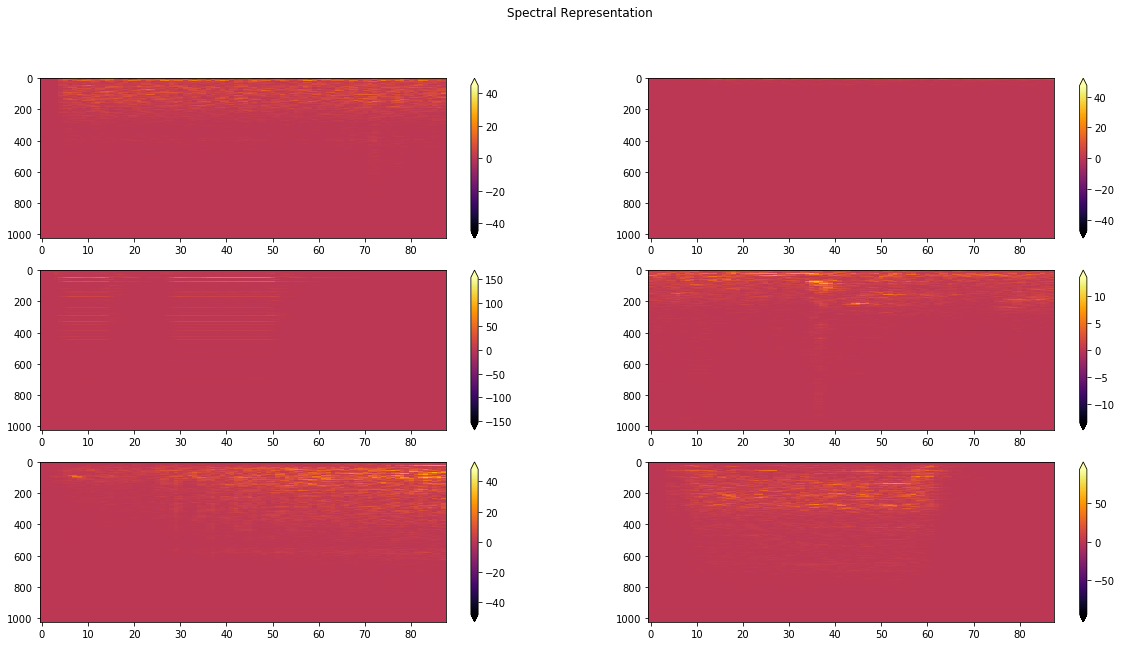

In [162]:
coeffs= []

# For the 1st label
coeffa = np.abs(librosa.stft(y=audio_data[out0[0]][:45000]))
coeffb = np.abs(librosa.stft(y=audio_data[out0[-1]][:45000]))
coeffs.append([coeffa, coeffb])

#For the 2nd label
coeffa = np.abs(librosa.stft(y=audio_data[out1[0]][:45000]))
coeffb = np.abs(librosa.stft(y=audio_data[out1[-1]][:45000]))
coeffs.append([coeffa, coeffb])

#For the 3rd label
coeffa = np.abs(librosa.stft(y=audio_data[out2[0]][:45000]))
coeffb = np.abs(librosa.stft(y=audio_data[out2[-1]][:45000]))
coeffs.append([coeffa, coeffb])

# Plot all
featPlot(coeffs,title='Spectral Representation')

---




#### 2.1.6 Chroma

We can visualize how the Chromas looks like for some of our sounds. We use here the chroma calculated for a fixed window (`chroma_dtft`)...

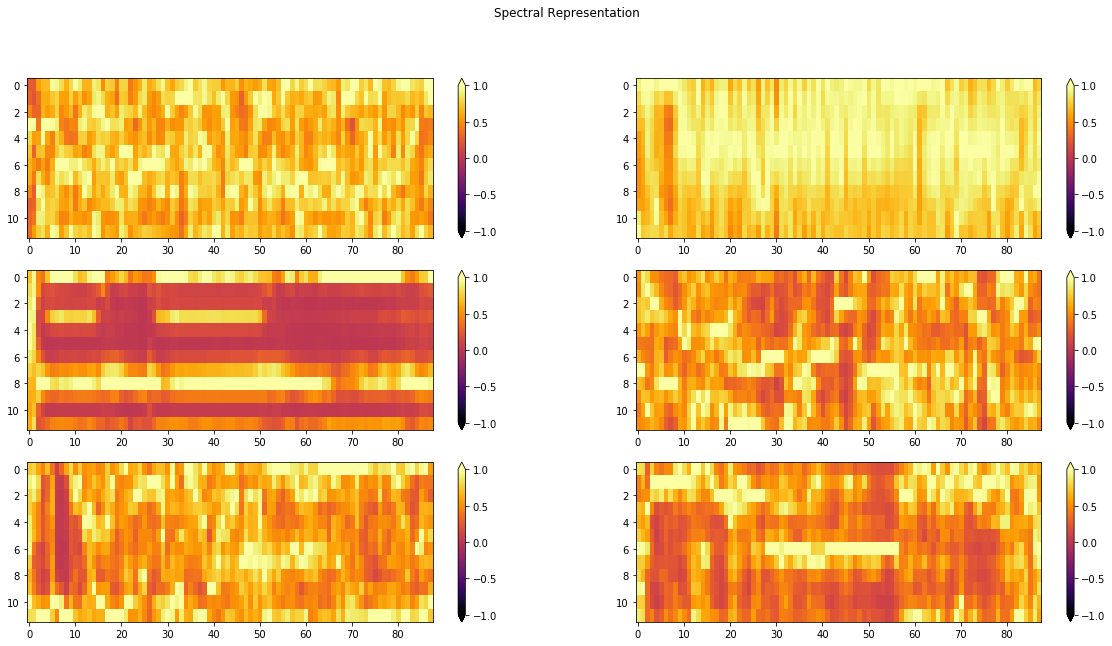

In [31]:
coeffs= []

# For the 1st label
coeffa = chroma_stft(y=audio_data[out0[0]][:45000], sr=44100)
coeffb = chroma_stft(y=audio_data[out0[-1]][:45000], sr=44100)
coeffs.append([coeffa, coeffb])

#For the 2nd label
coeffa = chroma_stft(y=audio_data[out1[0]][:45000], sr=44100)
coeffb = chroma_stft(y=audio_data[out1[-1]][:45000], sr=44100)
coeffs.append([coeffa, coeffb])

#For the 3rd label
coeffa = chroma_stft(y=audio_data[out2[0]][:45000], sr=44100)
coeffb = chroma_stft(y=audio_data[out2[-1]][:45000], sr=44100)
coeffs.append([coeffa, coeffb])

# Plot all
featPlot(coeffs,title='Spectral Representation')

---




#### 2.1.7 Tonne

A last option is to use the `tonnetz`function from the `librosa.feature` library, which gives an alternative representation of pitch and harmony...

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=704
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=352
  n_fft, y.shape[-1]


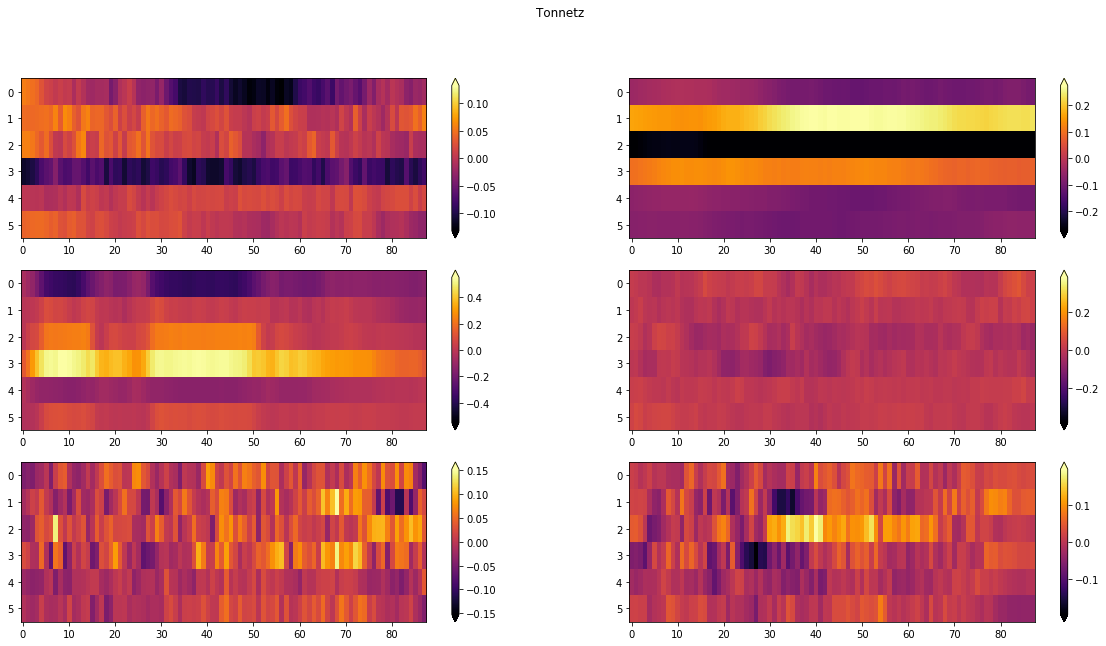

In [32]:
coeffs= []

# For the 1st label
coeffa = tonnetz(y=audio_data[out0[0]][:45000], sr=44100)
coeffb = tonnetz(y=audio_data[out0[-1]][:45000], sr=44100)
coeffs.append([coeffa, coeffb])

#For the 2nd label
coeffa = tonnetz(y=audio_data[out1[0]][:45000], sr=44100)
coeffb = tonnetz(y=audio_data[out1[-1]][:45000], sr=44100)
coeffs.append([coeffa, coeffb])

#For the 3rd label
coeffa = tonnetz(y=audio_data[out2[0]][:45000], sr=44100)
coeffb = tonnetz(y=audio_data[out2[-1]][:45000], sr=44100)
coeffs.append([coeffa, coeffb])

# Plot all
featPlot(coeffs,title='Tonnetz')

***
---




## 3. Machine Learning Model



We proceed now to train our ML model.

**Problem:** The wavelet transformation returns an array with dimension `len(scales)` * `len(data)` (with the size of our data it is of the order of some millions!).

**Solution:** We use the Principal Component Analysis (PCA) in order to reduce the dimensionality of the problem. The obtained arrays wil be rehaped to an 1D vector, and those vectors wil be used to train the model.

Before to start to evaluate the classification models, we define a class that will help us to train the model and to make other operations on the data sets...

In [1]:
class classML():
    """
    Class to define a classifier (using a machine learning model),
    to prepare the desired operations on the data sets and to obtain
    different metrics on the models.
    X : (array) Features
    Y : (array) Labels
    """
    # Initialize
    def __init__(self, X, Y, model_class='SVC', gamma='scale', test_size=0.2,
                 random_state=1234, data_shuffle=True, data_norm=True):
        # Copy variables
        self.X = X
        self.Y = Y
        self.gamma = gamma
        self.test_size = test_size
        self.ran_state = random_state
        self.data_norm = data_norm
        self.data_shuffle = data_shuffle
        self.model_class = model_class.lower()
        self.classifier = None
        # Normalize the data
        if self.data_norm:
            self.norm = StandardScaler()
            self.X = self.norm.fit_transform(self.X)
        # Suffle data before the splitting and the training
        if self.data_shuffle:
            self.X, self.Y = shuffle(self.X, self.Y)
        # Split training and test data
        # Convention: 0 = training
        #             1 = testing
        #             2 = predicted
        self.X0, self.X1, self.y0, self.y1 = train_test_split(self.X, self.Y,
                                                              test_size=self.test_size,
                                                              random_state=self.ran_state)
        # Initialize model
        print('Short summary. Model : {}'.format(self.model_class))
        print('Training + Test data. gamma : {}. Norm : {}. Shuffle : {}. test_size = {}.'.format(self.gamma,
              self.data_norm, self.data_shuffle, self.test_size))
        if self.model_class == 'svc':
            self.classifier = svm.SVC(gamma=self.gamma)
        elif self.model_class == 'knc':
            self.classifier = KNeighborsClassifier(3)
        elif self.model_class == 'gpc':
            self.classifier = GaussianProcessClassifier(RBF(1.0))
        elif self.model_class == 'dtc':
            self.classifier = DecisionTreeClassifier()
        elif self.model_class == 'rfc':
            self.classifier = RandomForestClassifier()
        elif self.model_class == 'mlpc':
            self.classifier = MLPClassifier(alpha=1, max_iter=1000)
        elif self.model_class == 'gnb':
            self.classifier = GaussianNB()
        elif self.model_class == 'qda':
            self.classifier = QuadraticDiscriminantAnalysis()
        elif self.model_class == 'abc':
            self.classifier = AdaBoostClassifier()

    # Model summary
    def summary(self):
        """
        Function to print the summary of the defined model
        """
        print('Short summary. Model : {}'.format(self.model_class))
        print('Training + Test data. gamma : {}. Norm : {}. Shuffle : {}. test_size = {}.'.format(self.gamma,
              self.data_norm, self.data_shuffle, self.test_size))

    # To train the model
    def train(self):
        """
        Function to train the defined model
        """
        self.classifier.fit(self.X0, self.y0)
        return self.classifier
        
    # To obtain the predictions:
    def pred(self):
        """
        Function to make predictions from the trained model.
        It only return the prediction
        """
        self.y2 = self.classifier.predict(self.x1)
        return self.y1, self.y2
    
    # To make predictions and calculate scores:
    def pred_score(self, save_vals=False):
        """
        Function to make predictions and calculate several scores.
        It not return the prediction, but print out several scores:
        1. Matrix confusion, 2. F1-Score and 3. Accuracy
        """
        self.save_vals = save_vals
        # Make a prediction
        self.y2 = self.classifier.predict(self.X1)
        # calculate scores
        self.f1_sc = f1_score(self.y1, self.y2, average='weighted')
        self.cmat = confusion_matrix(self.y1, self.y2) #, labels=["AC", "Car Horn", "Drilling"]
        self.n_rows, self.n_cols = self.y1.shape[0], self.cmat.shape[1]
        self.t_lab, self.f_lab = [], []
        self.t_tot, self.f_tot = 0, 0
        for i in range(self.n_cols):
            # True for i-th label
            self.ti = self.cmat[i][i]
            # Total true
            self.t_tot += self.ti
            # False for i-th label
            self.fi = 0
            for j in range(self.n_cols):
                if j != i:
                    self.fi += self.cmat[i][j]
            # Total false
            self.f_tot += self.fi
            # Save number of false and true Class. for i-th label
            self.t_lab.append(self.ti)
            self.f_lab.append(self.fi)
        # Print scores
        print('Confusion Matrix Values:')
        print('------------------------')
        for i in range(self.n_cols):
            print('\nLabel {} :'.format(i))
            print('True  : {}'.format(self.t_lab[i]))
            print('False : {}'.format(self.f_lab[i]))
            print('Total : {}'.format(self.t_lab[i]+self.f_lab[i]))
        print('\nMeasurements:')
        print('------------------------\n')
        print('F1 Score : {}'.format(self.f1_sc))
        print('Accuracy : {}'.format(self.t_tot/self.n_rows))
        print('Misclassification Rate : {}'.format(self.f_tot/self.n_rows))
        if self.save_vals:
            return self.f1_sc, self.t_tot/self.n_rows
        
    # Save Model
    def save_mod(self, folder=None, name=None):
        """
        Function to save the model to a file
        """
        # Target folder and file names
        if folder == None:
            folder = './models/'
        if name == None:
            name = 'model.joblib'
        # Full file names, inclusing path
        file = os.path.join(folder, name)
        # Check if folder exists
        if not os.path.isdir(folder_name):
            cmd = 'mkdir {}'.format(folder_name)
            os.system(cmd)
        # Save to npy files
        dump(self.classifier, file)
        print('Model saved to path : {}'.format(file))

We also need to keep an eye on the size of some arrays, in order to avoid to much memory consumption. Some arrays can reach 20 M elements. So we will try to keep them a bit smaller! To do so we will indicate the desired maximun size in memory for a given array, and then we will stimate the number of elements...

In [33]:
# Function to determine the Max. number of elements in an array
#  to avoid using TOO much RAM:
def max_elem(dim0, mem_val=5, ref_val=1.0):
    """
    Function to determine the number of elements on an array, to
    not exceed the specified size (in GB) in memory, once one of
    the dimentions have been specifiedt.
    dim0    : (int) One dimension of the array
    mem_val : (float, int...) Desired Max. value, in GB (5 GB by default)
    """
    # We get the memory size of one element, in bytes.
    # It can be machine/implementation dependent...
    ref_arr = np.array(ref_val)
    one_size = ref_arr.nbytes
    # We transform the Max. size from GB to B
    mem_max = mem_val * 1073741274
    # We will have now an array (dim0, dim_threshold)...
    # Total number of elements dim0 * dim_threshold will use
    # mem_val in memory...
    dim_threshold = int(mem_max / (one_size * dim0))
    print('For dim_0 : {}, Max. Num. of Elements : {}'.format(dim0, dim_threshold))
    return dim_threshold

---




### 3.1 Wavelet Transform, PCA and Support Vector Classifier

PCA and wavelet transformation, for all data points.

In [12]:
# Initialize PCA object
pca = PCA(n_components=1)

# Number of features (scales) and of points to use
dim_feat = 150
num_pts = 45000

# To avoid using TOO much RAM:
mem_max = 5 * 1073741274    # Max. Value in MB per array
# We will have now an array of dim (dim_feat), and each element use 8 bits...
# Total number of elements that uses around mem_max in MB ...
num_threshold = int(mem_max / (8 * dim_feat))
print('Max. Num. of Elements : {}'.format(num_threshold))

# Needed arrays
features = np.empty((0, dim_feat))
scales = np.arange(1, dim_feat + 1)

# Wavelet transformations and PCA for each audio data
print(':', end='')
for i in range(len(audio_data)):
    print('=', end='')
    # Check dimensions, to not exceed 5 GB per element in audio_data
    num_pts = audio_data[i].shape[0]
    if num_pts > num_threshold:
        num_pts = num_threshold
    # Wavelet Transform. Uses Morlet Wavelet.
    coeff, freqs = pywt.cwt(audio_data[i][:num_pts], scales, 'morl')
    del freqs
    # concatenation along the first axis after 1-D arrays of shape (N,)
    features = np.vstack([features, pca.fit_transform(coeff).flatten()])

Max. Num. of Elements : 4473921
:=========================================================================================================================================================================================================================================================================================

Check the `features` array dimensions:

Some lists are large, so we can help a bit saving them in a file and then deleting the corresponding list...

In [13]:
# Save the data arrays...

#load_save('sound', 'save', data=audio_data)
#load_save('labels', 'save', data=labels)
load_save('feat_wt', 'save', data=features)

feat_wt saved


In [ ]:
del audio_data

We can check now the size of the lists that will be used in our ML model:

In [14]:
features.shape

(281, 150)

In [15]:
labels = np.array(labels)
labels.shape

(281,)

#### 3.1.1: Without Normalization:

We initialize our first model, without using any normalization on the features

In [18]:
mod0 = classML(features, labels, data_norm=False)

Short summary. gamma : scale. Norm : False. Shuffle : True. test_size = 0.2


Now let's train `mod0` and to get its scores!

In [19]:
svc0 = mod0.train()
mod0.pred_score()

Confusion Matrix Values:
------------------------

Label 0 :
True  : 5
False : 5
Total : 10

Label 1 :
True  : 15
False : 13
Total : 28

Label 2 :
True  : 10
False : 9
Total : 19

Measurements:
------------------------

F1 Score : 0.5319020056535201
Accuracy : 0.5263157894736842
Misclassification Rate : 0.47368421052631576


A very bad accuracy! Around 40 %... We see that only the label 2 (drilling) was relatively well recognized, while the other two have a large number of false labelled sounds.

As a final step, we save our model:

In [20]:
# Target folder and file names
folder_name = './models/'
file_name = 'audio_svc_250_model0.joblib'

mod0.save_mod(folder=folder_name, name=file_name)

Model saved to path : ./models/audio_svc_250_model0.joblib


#### 3.1.2: With Normalization:

We initialize our second model, using a standard normalization on the features this time:

In [25]:
mod1 = classML(features, labels)

Short summary. gamma : scale. Norm : True. Shuffle : True. test_size = 0.2


And we train it and check the scores:

In [26]:
svc1 = mod1.train()
mod1.pred_score()

Confusion Matrix Values:
------------------------

Label 0 :
True  : 4
False : 4
Total : 8

Label 1 :
True  : 11
False : 13
Total : 24

Label 2 :
True  : 11
False : 14
Total : 25

Measurements:
------------------------

F1 Score : 0.46180928511755576
Accuracy : 0.45614035087719296
Misclassification Rate : 0.543859649122807


The accuracy is not better, but we do not see a large improvement! In particular, for the label 0 (air conditioner) we did not have any well labelled sound!

We save the model...

In [27]:
# Target folder and file names
folder_name = './models/'
file_name = 'audio_svc_250_model1.joblib'

mod1.save_mod(folder=folder_name, name=file_name)

Model saved to path : ./models/audio_svc_250_model1.joblib


Before to end the notebook, we clean some arrays (and Objects) in order to free some memory...

In [ ]:
del features
del labels
del mod0
del mod1

---




### 3.2 MFCC Coefficients

We try now to use another features to characterize the sounds: Mel-Frequency Cepstral Coefficients (MFCCs)...

We start verifying that `audio_data` is loaded:

In [ ]:
audio_data = load_save('sound', 'load')
labels = load_save('labels', 'load')

And now we extract the features (MFCCs) for each data set (sound) in `audio_data`:

In [35]:
# Some needed variables, to specify the number of features (MFCCs) and to save them
dim_feat = 125
features = np.empty((0, dim_feat))

dim_thr = max_elem(dim_feat)

# MFCCs extraction, using librosa
print(':', end='')

for ind in range(len(audio_data)):
    print('=', end='')
#    # Check dimensions, to not exceed size per feature in audio_data
#    num_pts = min(audio_data[i].shape[0], dim_threshold)
    # MFCCs
    mfccs  = librosa.feature.mfcc(y=audio_data[ind], sr=44100, n_mfcc=dim_feat)
    # Average for each feature...
    mfccs = np.mean(mfccs.T, axis=0)
    # concatenation along the first axis after 1-D arrays of shape (N,)
    features = np.vstack([features, mfccs])

print('\n\nFeatures shape:{}'.format(features.shape))

For dim_0 : 125, Max. Num. of Elements : 5368706
:=========================================================================================================================================================================================================================================================================================

Features shape:(281, 125)


Delete some arrays to save memory:

In [ ]:
del audio_data

#### 3.2.1: Without Normalization:

We use again the `SVC`, in order to compare the classification with our previous method. As a first attempt, we ignore the normalization.

In [38]:
mod2 = classML(features, labels, data_norm=False)

Short summary. gamma : scale. Norm : False. Shuffle : True. test_size = 0.2


Train and evaluate the classifier:

In [39]:
svc2 = mod2.train()
mod2.pred_score()

Confusion Matrix Values:
------------------------

Label 0 :
True  : 0
False : 9
Total : 9

Label 1 :
True  : 19
False : 7
Total : 26

Label 2 :
True  : 16
False : 6
Total : 22

Measurements:
------------------------

F1 Score : 0.5622826410166907
Accuracy : 0.6140350877192983
Misclassification Rate : 0.38596491228070173


The accuracy is slightly better as before! MFCCs apparently are better features than the Wavelet transform! But still the labeling for 0 is not performing well.

We save now the model and the features:

In [40]:
# Target folder and file names
folder_name = './models/'
file_name = 'audio_svc_150_model0_MFCCs.joblib'

mod2.save_mod(folder=folder_name, name=file_name)

Model saved to path : ./models/audio_svc_150_model0_MFCCs.joblib


In [41]:
# Save features
load_save('feat_mfcc', 'save', data=features)

feat_mfcc saved


#### 3.2.2 With Normalization:

And the same, but using normalization...

In [42]:
mod3 = classML(features, labels)

Short summary. gamma : scale. Norm : True. Shuffle : True. test_size = 0.2


In [22]:
svc3 = mod3.train()
mod3.pred_score()

Confusion Matrix Values:
------------------------

Label 0 :
True  : 2
False : 8
Total : 10

Label 1 :
True  : 19
False : 1
Total : 20

Label 2 :
True  : 20
False : 7
Total : 27

Measurements:
------------------------

F1 Score : 0.6967328473925155
Accuracy : 0.7192982456140351
Misclassification Rate : 0.2807017543859649


And the results are much better!

In [61]:
# Target folder and file names
folder_name = './models/'
file_name = 'audio_svc_150_model1_MFCCs.joblib'

mod3.save_mod(folder=folder_name, name=file_name)

Model saved to path : ./models/audio_svc_150_model1_MFCCs.joblib


---




### 3.3 Spectral Representation

We try now to use another features to characterize the sounds: the Contrast or the spectral respresentation...

We start again verifying that `audio_data` is loaded:

In [26]:
audio_data = load_save('sound', 'load')
labels = load_save('labels', 'load')

sound loaded
labels loaded


And now we calculate the spectral representation for each data set (sound) in `audio_data`:

In [52]:
# Some needed variables...
# FTT is quicker when the n_fft is a power of 2...
# See librosa.stft documentation for more details
sr = 44100      # sample rate
dt = 93         # sampling duration in ms
n0 = dt * sr / 1000
n0 = int(math.log(n0, 2))
n_fft = 2**n0
print('Length of windowed signal : {}'.format(n_fft))



# Num. of features
dim_feat = 1 + int(n_fft / 2)
features = np.empty((0, dim_feat))

# MFCCs extraction, using librosa
print(':', end='')

for ind in range(len(audio_data)):
    print('=', end='')
    # Spectral distribution
    spectral  = np.abs(librosa.stft(y=audio_data[ind], n_fft=n_fft))
    # Average for each feature...
    spectral = np.mean(spectral.T, axis=0)
    # concatenation along the first axis after 1-D arrays of shape (N,)
    features = np.vstack([features, spectral])

print('\n\nFeatures shape:{}'.format(features.shape))

Length of windowed signal : 4096
:=========================================================================================================================================================================================================================================================================================

Features shape:(281, 2049)


Delete some arrays to save memory:

In [54]:
del audio_data

#### 3.2.1: Without Normalization:

We use again the `SVC`, in order to compare the classification with our previous method. As a first attempt, we ignore the normalization.

In [53]:
mod4 = classML(features, labels, data_norm=False)

Short summary. gamma : scale. Norm : False. Shuffle : True. test_size = 0.2


Train and evaluate the classifier:

In [54]:
svc4 = mod4.train()
mod4.pred_score()

Confusion Matrix Values:
------------------------

Label 0 :
True  : 2
False : 4
Total : 6

Label 1 :
True  : 21
False : 2
Total : 23

Label 2 :
True  : 20
False : 8
Total : 28

Measurements:
------------------------

F1 Score : 0.7482456140350878
Accuracy : 0.7543859649122807
Misclassification Rate : 0.24561403508771928


The accuracy is much better than for MFCCs and for the Wavelet transform!

We save now the model and the features:

In [55]:
# Target folder and file names
folder_name = './models/'
file_name = 'audio_svc_88_model0_Spectral.joblib'

mod4.save_mod(folder=folder_name, name=file_name)

Model saved to path : ./models/audio_svc_88_model0_Spectral.joblib


In [56]:
# Save features
load_save('feat_spectral', 'save', data=features, file_name='feat_spectral_88_data.npy')

feat_spectral saved


#### 3.2.2 With Normalization:

And the same, but using normalization...

In [59]:
mod5 = classML(features, labels)

Short summary. gamma : scale. Norm : True. Shuffle : True. test_size = 0.2


In [60]:
svc5 = mod5.train()
mod5.pred_score()

Confusion Matrix Values:
------------------------

Label 0 :
True  : 0
False : 13
Total : 13

Label 1 :
True  : 24
False : 1
Total : 25

Label 2 :
True  : 15
False : 4
Total : 19

Measurements:
------------------------

F1 Score : 0.5973266499582289
Accuracy : 0.6842105263157895
Misclassification Rate : 0.3157894736842105


Using normalization the results are slightly worse than before...

In [62]:
# Target folder and file names
folder_name = './models/'
file_name = 'audio_svc_88_model1_Spectral.joblib'

mod5.save_mod(folder=folder_name, name=file_name)

Model saved to path : ./models/audio_svc_88_model1_Spectral.joblib


---




### 3.4 Chroma

We try now to use another features to characterize the sounds: the Chroma, used to identify the pitch...

We start again verifying that `audio_data` is loaded:

In [ ]:
audio_data = load_save('sound', 'load')
labels = load_save('labels', 'load')

And now we extract the Chroma for each data set (sound) in `audio_data`:

In [64]:
# Some initialization variables...
dim_feat = 24
features = np.empty((0, dim_feat))

for ind in range(len(audio_data)):
    print('=', end='')
    # Spectral distribution
    chr_  = chroma_stft(y=audio_data[ind], sr=44100, n_chroma=dim_feat)
    chr_ = np.mean(chr_.T, axis=0)
    # concatenation along the first axis after 1-D arrays of shape (N,)
    features = np.vstack([features, chr_])

print('\n\nFeatures shape:{}'.format(features.shape))


Features shape:(281, 24)


Delete some arrays to save memory:

In [ ]:
del audio_data

#### 3.2.1: Without Normalization:

We use again the `SVC`, in order to compare the classification with our previous methods. As a first attempt, we ignore the normalization.

In [80]:
mod6 = classML(features, labels, data_norm=False)

Short summary. gamma : scale. Norm : False. Shuffle : True. test_size = 0.2


Train and evaluate the classifier:

In [81]:
svc6 = mod6.train()
mod6.pred_score()

Confusion Matrix Values:
------------------------

Label 0 :
True  : 4
False : 8
Total : 12

Label 1 :
True  : 17
False : 7
Total : 24

Label 2 :
True  : 18
False : 3
Total : 21

Measurements:
------------------------

F1 Score : 0.6681597611048898
Accuracy : 0.6842105263157895
Misclassification Rate : 0.3157894736842105


The accuracy is slightly worse than the previous case...

We save now the model and the features:

In [82]:
# Target folder and file names
folder_name = './models/'
file_name = 'audio_svc_24_model0_Chr.joblib'

mod6.save_mod(folder=folder_name, name=file_name)

Model saved to path : ./models/audio_svc_24_model0_Chr.joblib


In [83]:
# Save features
load_save('feat_chr', 'save', data=features, file_name='feat_chroma_24_data.npy')

feat_chr saved


#### 3.2.2 With Normalization:

And the same, but using normalization...

In [84]:
mod7 = classML(features, labels)

Short summary. gamma : scale. Norm : True. Shuffle : True. test_size = 0.2


In [85]:
svc7 = mod7.train()
mod7.pred_score()

Confusion Matrix Values:
------------------------

Label 0 :
True  : 3
False : 8
Total : 11

Label 1 :
True  : 12
False : 14
Total : 26

Label 2 :
True  : 18
False : 2
Total : 20

Measurements:
------------------------

F1 Score : 0.5560462928883982
Accuracy : 0.5789473684210527
Misclassification Rate : 0.42105263157894735


We do not see improvements in our results...

In [75]:
# Target folder and file names
folder_name = './models/'
file_name = 'audio_svc_24_model1_Chroma.joblib'

mod7.save_mod(folder=folder_name, name=file_name)

Model saved to path : ./models/audio_svc_88_model1_Chroma.joblib


---




### 3.5 Mel-Scale Spectrogram

Another feature to explore is the Mel-Scale spectrogram.

We start, as always, verifying that `audio_data` is loaded:

In [ ]:
audio_data = load_save('sound', 'load')
labels = load_save('labels', 'load')

And now we calculate the Mel-Scale for each data set (sound) in `audio_data`:

In [86]:
# Initialization variables:
dim_feat = 128
features = np.empty((0, dim_feat))

for ind in range(len(audio_data)):
    print('=', end='')
    # Spectral distribution
    melspec  = melspectrogram(y=audio_data[ind], sr=44100, n_mels=dim_feat)
    melspec = np.mean(melspec.T, axis=0)
    # concatenation along the first axis after 1-D arrays of shape (N,)
    features = np.vstack([features, melspec])

print('\n\nFeatures shape:{}'.format(features.shape))


Features shape:(281, 128)


Delete some arrays to save memory:

In [ ]:
del audio_data

#### 3.2.1: Without Normalization:

We use again the `SVC`, in order to compare the classification with our previous method. As a first attempt, we ignore the normalization.

In [97]:
mod8 = classML(features, labels, data_norm=False)

Short summary. gamma : scale. Norm : False. Shuffle : True. test_size = 0.2


Train and evaluate the classifier:

In [98]:
svc8 = mod8.train()
mod8.pred_score()

Confusion Matrix Values:
------------------------

Label 0 :
True  : 0
False : 10
Total : 10

Label 1 :
True  : 5
False : 17
Total : 22

Label 2 :
True  : 23
False : 2
Total : 25

Measurements:
------------------------

F1 Score : 0.40471923536439663
Accuracy : 0.49122807017543857
Misclassification Rate : 0.5087719298245614


The accuracy is particular bad, but apparently recognized several sounds for label 2!

We save now the model and the features:

In [99]:
# Target folder and file names
folder_name = './models/'
file_name = 'audio_svc_128_model0_mel.joblib'

mod8.save_mod(folder=folder_name, name=file_name)

Model saved to path : ./models/audio_svc_128_model0_mel.joblib


In [100]:
# Save features
load_save('feat_mel', 'save', data=features, file_name='feat_mel_128_data.npy')

feat_mel saved


#### 3.2.2 With Normalization:

And the same, but using normalization...

In [103]:
mod9 = classML(features, labels)

Short summary. gamma : scale. Norm : True. Shuffle : True. test_size = 0.2


In [104]:
svc9 = mod9.train()
mod9.pred_score()

Confusion Matrix Values:
------------------------

Label 0 :
True  : 0
False : 8
Total : 8

Label 1 :
True  : 20
False : 1
Total : 21

Label 2 :
True  : 13
False : 15
Total : 28

Measurements:
------------------------

F1 Score : 0.5380116959064328
Accuracy : 0.5789473684210527
Misclassification Rate : 0.42105263157894735


We see an improvement in our results...

In [105]:
# Target folder and file names
folder_name = './models/'
file_name = 'audio_svc_128_model1_mel.joblib'

mod9.save_mod(folder=folder_name, name=file_name)

Model saved to path : ./models/audio_svc_128_model1_mel.joblib


---




### 3.6 Tonnetz

To finalize the feature exploration, we use now the tonnetz, given, of course, by the `tonnetz` function.

We start verifying if the audio and labels data are loaded:

In [ ]:
audio_data = load_save('sound', 'load')
labels = load_save('labels', 'load')

And now we extract the features (tonnetz) for each data set (sound) in `audio_data`:

In [106]:
# Initialization variables:
dim_feat = 6
features = np.empty((0, dim_feat))

for ind in range(len(audio_data)):
    print('=', end='')
    # Spectral distribution
    tonne = tonnetz(y=audio_data[ind], sr=44100)
    tonne = np.mean(tonne.T, axis=0)
    # concatenation along the first axis after 1-D arrays of shape (N,)
    features = np.vstack([features, tonne])

print('\n\nFeatures shape:{}'.format(features.shape))

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=761
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=381
  n_fft, y.shape[-1]


/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=768
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=563
  n_fft, y.shape[-1]


/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=936
  n_fft, y.shape[-1]


===

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=825
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=413
  n_fft, y.shape[-1]


=====

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=692
  n_fft, y.shape[-1]


/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=664
  n_fft, y.shape[-1]


==

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=924
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=1017
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=509
  n_fft, y.shape[-1]


====

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=710
  n_fft, y.shape[-1]


====

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=726
  n_fft, y.shape[-1]


=====

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=971
  n_fft, y.shape[-1]


==

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=588
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=294
  n_fft, y.shape[-1]


/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=948
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=474
  n_fft, y.shape[-1]


==

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=986
  n_fft, y.shape[-1]


==

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=880
  n_fft, y.shape[-1]


====

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=964
  n_fft, y.shape[-1]


==

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=797
  n_fft, y.shape[-1]


/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=958
  n_fft, y.shape[-1]


===

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=989
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=495
  n_fft, y.shape[-1]


==

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=631
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=316
  n_fft, y.shape[-1]


==

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=904
  n_fft, y.shape[-1]


==

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=690
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=345
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=672
  n_fft, y.shape[-1]


/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=565
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=283
  n_fft, y.shape[-1]


====

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=541
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=271
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=136
  n_fft, y.shape[-1]


/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=925
  n_fft, y.shape[-1]


==

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=931
  n_fft, y.shape[-1]


==

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=142
  n_fft, y.shape[-1]


=

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=856
  n_fft, y.shape[-1]


/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=960
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=480
  n_fft, y.shape[-1]


==

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=902
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=451
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=226
  n_fft, y.shape[-1]


/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=731
  n_fft, y.shape[-1]


====

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=695
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=348
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=174
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=87
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=771
  n_fft, y.shape[-1]


===

/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=751
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=376
  n_fft, y.shape[-1]


/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=824
  n_fft, y.shape[-1]


/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=937
  n_fft, y.shape[-1]
/home/carlos/.local/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=766
  n_fft, y.shape[-1]



Features shape:(281, 6)


Delete some arrays to save memory:

In [ ]:
del audio_data

#### 3.2.1: Without Normalization:

We use again the `SVC`, in order to compare the classification with our previous method. As a first attempt, we ignore the normalization.

In [111]:
mod10 = classML(features, labels, data_norm=False)

Short summary. gamma : scale. Norm : False. Shuffle : True. test_size = 0.2


Train and evaluate the classifier:

In [112]:
svc10 = mod10.train()
mod10.pred_score()

Confusion Matrix Values:
------------------------

Label 0 :
True  : 0
False : 7
Total : 7

Label 1 :
True  : 17
False : 6
Total : 23

Label 2 :
True  : 22
False : 5
Total : 27

Measurements:
------------------------

F1 Score : 0.641186299081036
Accuracy : 0.6842105263157895
Misclassification Rate : 0.3157894736842105


The accuracy is not relatively good, and we have a lot of problems with the data, for sounds of short duration!

We save now the model and the features:

In [113]:
# Target folder and file names
folder_name = './models/'
file_name = 'audio_svc_6_model0_tonne.joblib'

mod10.save_mod(folder=folder_name, name=file_name)

Model saved to path : ./models/audio_svc_6_model0_tonne.joblib


In [114]:
# Save features
load_save('feat_tonne', 'save', data=features, file_name='feat_tonne_6_data.npy')

feat_tonne saved


#### 3.2.2 With Normalization:

And the same, but using normalization...

In [127]:
mod11 = classML(features, labels)

Short summary. gamma : scale. Norm : True. Shuffle : True. test_size = 0.2


In [128]:
svc11 = mod11.train()
mod11.pred_score()

Confusion Matrix Values:
------------------------

Label 0 :
True  : 0
False : 7
Total : 7

Label 1 :
True  : 15
False : 15
Total : 30

Label 2 :
True  : 16
False : 4
Total : 20

Measurements:
------------------------

F1 Score : 0.5077904551588762
Accuracy : 0.543859649122807
Misclassification Rate : 0.45614035087719296


We see a worse results than before...

In [129]:
# Target folder and file names
folder_name = './models/'
file_name = 'audio_svc_6_model1_tonne.joblib'

mod9.save_mod(folder=folder_name, name=file_name)

Model saved to path : ./models/audio_svc_6_model1_tonne.joblib


---




### 3.7 MFCC + Spectral + Chroma + Mel + Tonnentz

Now we will see how the model behaves when we use several features at the same time!

We saved before the features on different files. Now we can load them...

In [134]:
feat_mfcc  = load_save('feat_mfcc', 'load')
feat_spec  = load_save('feat_spectral', 'load', file_name='feat_spectral_2049_data.npy')
feat_chr   = load_save('feat_chr', 'load', file_name='feat_chroma_24_data.npy')
feat_mel   = load_save('feat_mel', 'load', file_name='feat_mel_128_data.npy')
feat_tonne = load_save('feat_tonne', 'load', file_name='feat_tonne_6_data.npy')

feat_mfcc loaded
feat_spectral loaded
feat_chr loaded
feat_mel loaded
feat_tonne loaded


In [135]:
print(feat_mfcc.shape)
print(feat_spec.shape)
print(feat_chr.shape)
print(feat_mel.shape)
print(feat_tonne.shape)

(281, 125)
(281, 2049)
(281, 24)
(281, 128)
(281, 6)


And now we concatenate all features in one large array... (`125 + 2049 + 24 + 128 + 6 = 2332` features!)

In [136]:
features_all = np.concatenate((feat_mfcc, feat_spec, feat_chr,
                               feat_mel, feat_tonne),
                             axis=1)

features_all.shape

(281, 2332)

We initialize our model, considering our features without normalization.

In [229]:
modA = classML(features_all, labels, data_norm=False)

Short summary. Model : svc
Training + Test data. gamma : scale. Norm : False. Shuffle : True. test_size = 0.2.


Initialize an empty array, in order to save all the scores...

In [245]:
scores_all = []

Train and evaluate the classifier:

In [246]:
svcA = modA.train()
f1, acc = modA.pred_score(save_vals=True)
scores_all.append(['SVC', f1, acc])

Confusion Matrix Values:
------------------------

Label 0 :
True  : 0
False : 10
Total : 10

Label 1 :
True  : 22
False : 1
Total : 23

Label 2 :
True  : 16
False : 8
Total : 24

Measurements:
------------------------

F1 Score : 0.6043970008895667
Accuracy : 0.6666666666666666
Misclassification Rate : 0.3333333333333333


At a first glance, it looks like we have an accuracy close to the average of the previous accuracies. The model can perform better!

---




### 3.8 Other Classifiers

Now that we check everything using SVC, we can compare with other classifiers!

---




#### 3.8.1 K Neighbors Classifier

In [247]:
modA0 = classML(features_all, labels, data_norm=False, model_class='KNC')
classA0 = modA0.train()
f1, acc = modA0.pred_score(save_vals=True)
scores_all.append(['KNC', f1, acc])

Short summary. Model : knc
Training + Test data. gamma : scale. Norm : False. Shuffle : True. test_size = 0.2.
Confusion Matrix Values:
------------------------

Label 0 :
True  : 4
False : 2
Total : 6

Label 1 :
True  : 23
False : 7
Total : 30

Label 2 :
True  : 17
False : 4
Total : 21

Measurements:
------------------------

F1 Score : 0.7832123411978222
Accuracy : 0.7719298245614035
Misclassification Rate : 0.22807017543859648


---




#### 3.8.2 Gaussian Process Classifier

In [248]:
modA1 = classML(features_all, labels, data_norm=False, model_class='gpc')
classA1 = modA1.train()
f1, acc = modA1.pred_score(save_vals=True)
scores_all.append(['GPC', f1, acc])

Short summary. Model : gpc
Training + Test data. gamma : scale. Norm : False. Shuffle : True. test_size = 0.2.
Confusion Matrix Values:
------------------------

Label 0 :
True  : 0
False : 10
Total : 10

Label 1 :
True  : 0
False : 23
Total : 23

Label 2 :
True  : 24
False : 0
Total : 24

Measurements:
------------------------

F1 Score : 0.24951267056530213
Accuracy : 0.42105263157894735
Misclassification Rate : 0.5789473684210527


---




#### 3.8.3 Decision Tree Classifier

In [253]:
modA2 = classML(features_all, labels, data_norm=False, model_class='DTC')
classA2 = modA2.train()
f1, acc = modA2.pred_score(save_vals=True)
scores_all.append(['DTC', f1, acc])

Short summary. Model : dtc
Training + Test data. gamma : scale. Norm : False. Shuffle : True. test_size = 0.2.
Confusion Matrix Values:
------------------------

Label 0 :
True  : 3
False : 7
Total : 10

Label 1 :
True  : 18
False : 6
Total : 24

Label 2 :
True  : 19
False : 4
Total : 23

Measurements:
------------------------

F1 Score : 0.6892442307270052
Accuracy : 0.7017543859649122
Misclassification Rate : 0.2982456140350877


---




#### 3.8.4 Random Forest Classifier

In [254]:
modA3 = classML(features_all, labels, data_norm=False, model_class='RFC')
classA3 = modA3.train()
f1, acc = modA3.pred_score(save_vals=True)
scores_all.append(['RFC', f1, acc])

Short summary. Model : rfc
Training + Test data. gamma : scale. Norm : False. Shuffle : True. test_size = 0.2.
Confusion Matrix Values:
------------------------

Label 0 :
True  : 5
False : 4
Total : 9

Label 1 :
True  : 18
False : 6
Total : 24

Label 2 :
True  : 22
False : 2
Total : 24

Measurements:
------------------------

F1 Score : 0.7849999999999999
Accuracy : 0.7894736842105263
Misclassification Rate : 0.21052631578947367


---




#### 3.8.5 MLP Classifier

In [255]:
modA4 = classML(features_all, labels, data_norm=False, model_class='MLPC')
classA4 = modA4.train()
f1, acc = modA4.pred_score(save_vals=True)
scores_all.append(['MLPC', f1, acc])

Short summary. Model : mlpc
Training + Test data. gamma : scale. Norm : False. Shuffle : True. test_size = 0.2.
Confusion Matrix Values:
------------------------

Label 0 :
True  : 4
False : 3
Total : 7

Label 1 :
True  : 20
False : 7
Total : 27

Label 2 :
True  : 18
False : 5
Total : 23

Measurements:
------------------------

F1 Score : 0.7593599383073066
Accuracy : 0.7368421052631579
Misclassification Rate : 0.2631578947368421


---




#### 3.8.6 Ada Boost Classifier

In [256]:
modA5 = classML(features_all, labels, data_norm=False, model_class='ABC')
classA5 = modA5.train()
f1, acc = modA5.pred_score(save_vals=True)
scores_all.append(['ABC', f1, acc])

Short summary. Model : abc
Training + Test data. gamma : scale. Norm : False. Shuffle : True. test_size = 0.2.
Confusion Matrix Values:
------------------------

Label 0 :
True  : 2
False : 2
Total : 4

Label 1 :
True  : 20
False : 8
Total : 28

Label 2 :
True  : 22
False : 3
Total : 25

Measurements:
------------------------

F1 Score : 0.7772053144329564
Accuracy : 0.7719298245614035
Misclassification Rate : 0.22807017543859648


---




#### 3.8.7 Gaussian NB

In [259]:
modA6 = classML(features_all, labels, data_norm=False, model_class='GNB')
classA6 = modA6.train()
f1, acc = modA6.pred_score(save_vals=True)
scores_all.append(['GNB', f1, acc])

Short summary. Model : gnb
Training + Test data. gamma : scale. Norm : False. Shuffle : True. test_size = 0.2.
Confusion Matrix Values:
------------------------

Label 0 :
True  : 10
False : 1
Total : 11

Label 1 :
True  : 5
False : 19
Total : 24

Label 2 :
True  : 14
False : 8
Total : 22

Measurements:
------------------------

F1 Score : 0.5135566188197768
Accuracy : 0.5087719298245614
Misclassification Rate : 0.49122807017543857


---




#### 3.8.8 Quadratic Discriminant Analysis

In [260]:
modA7 = classML(features_all, labels, data_norm=False, model_class='QDA')
classA7 = modA7.train()
f1, acc = modA7.pred_score(save_vals=True)
scores_all.append(['QDA', f1, acc])

Short summary. Model : qda
Training + Test data. gamma : scale. Norm : False. Shuffle : True. test_size = 0.2.
Confusion Matrix Values:
------------------------

Label 0 :
True  : 1
False : 9
Total : 10

Label 1 :
True  : 19
False : 3
Total : 22

Label 2 :
True  : 12
False : 13
Total : 25

Measurements:
------------------------

F1 Score : 0.5278600541758437
Accuracy : 0.5614035087719298
Misclassification Rate : 0.43859649122807015


/opt/intel/intelpython3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


---

### 3.9 Summary

Here some of the scores for the different classification methods:

In [268]:
import pandas as pd
scores_all = np.array(scores_all)
df_scores = pd.DataFrame(scores_all, columns=['Method', 'F1-Score', 'Accuracy'])

In [270]:
df_scores.head(9)

,Method,F1-Score,Accuracy
0,SVC,0.6043970008895667,0.6666666666666666
1,KNC,0.7832123411978222,0.7719298245614035
2,GPC,0.24951267056530213,0.42105263157894735
3,DTC,0.6892442307270052,0.7017543859649122
4,RFC,0.7849999999999999,0.7894736842105263
5,MLPC,0.7593599383073066,0.7368421052631579
6,ABC,0.7772053144329564,0.7719298245614035
7,GNB,0.5135566188197768,0.5087719298245614
8,QDA,0.5278600541758437,0.5614035087719298


---
***
---